# Comparison with different CPU Frequencies

In [92]:
#parse bandwidth result, each test is repeated 3 times
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
def parse_line_cpu(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    x = [int(i.split(':')[1]) for i in x]
    x=np.asarray(x,dtype='float')
    return x
def parse_line_io(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    x=np.asarray(x)[2:]
    x=np.asarray(x,dtype='float')
    return x
#parse dd perf result
def parse_line_perf(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    ax=list()
    for ix in x:
        if '#' in ix:
            ix = ix.split('#')[1].strip().split(' ')[0].strip('%')
            ax.append(ix)
    ax=np.asarray(ax,dtype='float')
    return ax
# Linear Fit and Plot
def plt_fit(has_cpu1,has_io_avg,xlabel=None,ylabel=None):
    from scipy import stats
    import sys
    has_cpu1=has_cpu1
    has_io_avg=has_io_avg
    slope, intercept, r_value, p_value, std_err = stats.linregress(has_cpu1,has_io_avg)
    print 'slope:%.2f'%slope
    print 'intercept:%.2f'%intercept
    print 'r-square:%.2f'%(r_value*r_value)
    predict_y = slope*has_cpu1+intercept
    x=has_cpu1
    y=has_io_avg
    pred_error = y - predict_y
    degrees_of_freedom = len(x) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    # Plotting
    plt.plot(x, y, 'o',label='data')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, predict_y, 'k-',label='fitting,r^2=%.2f'%(r_value*r_value))
    plt.legend(loc='upper left')
    plt.show()
    return slope,intercept,r_value*r_value

In [149]:
#log files, perf detials:
knl_perf_f="../log/knl.err"
has_perf_f="../log/haswell.err"
#user specified cpu scaling freqs
knl_cpu_f='../log/cpu_knl.txt'
has_cpu_f='../log/cpu_has.txt'
#observed io bw
has_io_f='../log/haswell.3711608.bw'
knl_io_f='../log/knl.3711609.bw'

#parse all files
knl_cpu=parse_line_cpu(knl_cpu_f)
has_cpu=parse_line_cpu(has_cpu_f)
knl_perfs=parse_line_perf(knl_perf_f)
has_perfs=parse_line_perf(has_perf_f)
has_io=parse_line_io(has_io_f)
knl_io=parse_line_io(knl_io_f)

#reshaping io and perfs
knl_perfs=knl_perfs.reshape(-1,8) # there are 8 columns in the perf result, e.g., IPC, context-switch, etc
has_perfs=has_perfs.reshape(-1,8)

#calculating mean/max/min
import numpy as np
for x in range(len(knl_io)):
    if knl_io[x] < 10:
        knl_io[x]=knl_io[x]*1024
for x in range(len(has_io)):
    if has_io[x] < 10:
        has_io[x]=has_io[x]*1024
import pandas as pd
df_knl=pd.DataFrame(knl_perfs)
df_has=pd.DataFrame(has_perfs)
df_knl.columns=['CPUuti','Contxtsw',
                'cpumig','pageft',
                'ClockRate','IPC','branch','branchmis']
df_has.columns=['CPUuti','Contxtsw',
                'cpumig','pageft',
                'ClockRate','IPC','branch','branchmis']

df_knl_cpu=pd.DataFrame({'userset':knl_cpu})
df_knl=df_knl.join(df_knl_cpu)

df_has_cpu=pd.DataFrame({'userset':has_cpu})
df_has=df_has.join(df_has_cpu)

df_knl_io=pd.DataFrame({'io':knl_io})
df_knl=df_knl.join(df_knl_io)
df_has_io=pd.DataFrame({'io':has_io})
df_has=df_has.join(df_has_io)
df_has['userset']=df_has['userset'].apply(lambda x : x/1000000.0)
df_knl['userset']=df_knl['userset'].apply(lambda x : x/1000000.0)

In [150]:
df_knl_same=df_knl[(df_knl['userset'] <=1.4) & (df_knl['userset'] >=1.2)]
df_has_same=df_has[(df_has['userset'] <=1.4) & (df_has['userset'] >=1.2)]

# IO~ClockRate on Haswell

slope:201.30
intercept:415.31
r-square:0.76


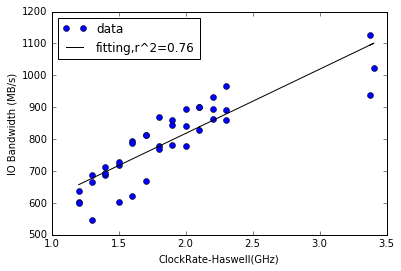

(201.30315647922004, 415.31325037589676, 0.76211345180699785)

In [170]:
plt_fit(df_has['ClockRate'],df_has['io'],'ClockRate-Haswell(GHz)','IO Bandwidth (MB/s)')

# IO~ClockRate on KNL

slope:172.95
intercept:54.19
r-square:0.94


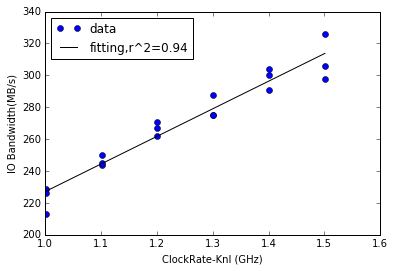

(172.95238095238096, 54.192126984126929, 0.93910171103563933)

In [171]:
plt_fit(df_knl['ClockRate'],df_knl['io'],'ClockRate-Knl (GHz)','IO Bandwidth(MB/s)')

In [168]:
dic_has={}
dic_knl={}
dic_hasknl={}
frames=[df_knl_same,df_has_same]
df_hasknl=pd.concat(frames,ignore_index=True)
def plot_same():  # select the cpu-freq that both kNL and Haswell have, e..g, 1.4Ghz, then fit it with it's IO
    for icl in df_has_same.columns:
        (k,b,rs)=plt_fit(df_has_same[icl],df_has_same['io'],icl+'-haswell','IO Bandwidth')
        dic_has[icl]=rs
        (k,b,rs)=plt_fit(df_knl_same[icl],df_knl_same['io'],icl+'-knl','IO Bandwidth')
        dic_knl[icl]=rs
        (k,b,rs)=plt_fit(df_hasknl[icl],df_hasknl['io'],icl+'-hasknl','IO Bandwidth')
        dic_hasknl[icl]=rs
    print "HASWELL"
    for key, value in sorted(dic_has.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "KNL"
    for key, value in sorted(dic_knl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "HASWELL-KNL"
    for key, value in sorted(dic_hasknl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
dic_has={}
dic_knl={}
dic_hasknl={}
frames=[df_knl,df_has]
df_hasknl=pd.concat(frames,ignore_index=True)
def plot_all(): # fit and plot all data for both knl and haswell
    for icl in df_has.columns:
        (k,b,rs)=plt_fit(df_has[icl],df_has['io'],icl+'-haswell','IO Bandwidth')
        dic_has[icl]=rs
        (k,b,rs)=plt_fit(df_knl[icl],df_knl['io'],icl+'-knl','IO Bandwidth')
        dic_knl[icl]=rs
        (k,b,rs)=plt_fit(df_hasknl[icl],df_hasknl['io'],icl+'-hasknl','IO Bandwidth')
        dic_hasknl[icl]=rs
    print "HASWELL"
    for key, value in sorted(dic_has.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "KNL"
    for key, value in sorted(dic_knl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)
    print ('\n')
    print "HASWELL-KNL"
    for key, value in sorted(dic_hasknl.iteritems(), key=lambda (k,v): (v,k)):
        print "%s\t\t%.2f" % (key, value)

# Regression Analysis 

In [169]:
#df_hasknl
from sklearn.decomposition import PCA
pca =PCA(n_components=4)
pca.fit(df_hasknl)
#IPC + cpu-mig(K/sec) + pageft(K/sec) + ClockRate(Ghz) + branch(M/sec) + branchmis(%)

PCA(copy=True, n_components=4, whiten=False)

# Regression KNL and Haswell together

In [139]:
import statsmodels.api as sm
from patsy import dmatrices
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_hasknl, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                     io   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     392.4
Date:                Wed, 22 Feb 2017   Prob (F-statistic):           3.76e-38
Time:                        08:41:52   Log-Likelihood:                -300.88
No. Observations:                  57   AIC:                             611.8
Df Residuals:                      52   BIC:                             622.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     44.9764    157.144      0.286      0.7

# Regression Haswell only

In [140]:
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_has, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                     io   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     47.48
Date:                Wed, 22 Feb 2017   Prob (F-statistic):           1.87e-13
Time:                        08:42:43   Log-Likelihood:                -207.28
No. Observations:                  39   AIC:                             424.6
Df Residuals:                      34   BIC:                             432.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1059.8641    691.648      1.532      0.1

# Regression KNL only

In [141]:
y, X = dmatrices('io ~ IPC + pageft + ClockRate + branch', data=df_knl, return_type='dataframe')
mod = sm.OLS(y, X)
result=mod.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                     io   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     85.76
Date:                Wed, 22 Feb 2017   Prob (F-statistic):           3.29e-09
Time:                        08:43:21   Log-Likelihood:                -57.258
No. Observations:                  18   AIC:                             124.5
Df Residuals:                      13   BIC:                             129.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      7.9237    247.784      0.032      0.9

In [187]:
df_has_mean=pd.to_numeric(df_has.groupby(df_has.index / 3).mean()['io'])
df_has_max=pd.to_numeric(df_has.groupby(df_has.index / 3).max()['io'])
df_has_min=pd.to_numeric(df_has.groupby(df_has.index / 3).min()['io'])
df_knl_mean=pd.to_numeric(df_knl.groupby(df_knl.index / 3).mean()['io'])
df_knl_max=pd.to_numeric(df_knl.groupby(df_knl.index / 3).max()['io'])
df_knl_min=pd.to_numeric(df_knl.groupby(df_knl.index / 3).min()['io'])

# Plot the date tegother 

In [199]:
#r-sqr>0.61
#Haswell-KNL: pagefalut, branch, branchmiss, IPC,
#KNL: branch, clockrate,pagefault, IPC
#HASWELL: pagefault, branch, Clockrate, IPC

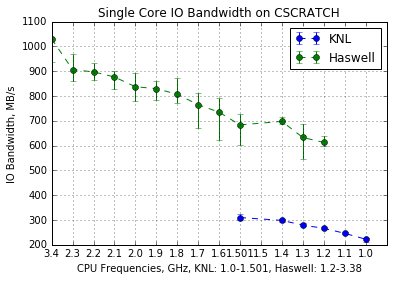

In [200]:
all_cpu=[3.38, 2.2999999999999998, 2.2000000000000002, 
         2.1000000000000001, 2.0, 1.8999999999999999, 
         1.8, 1.7, 1.6000000000000001, 1.501, 1.50,
         1.3999999999999999, 1.3, 1.2,1.1000000000000001, 1.0]
has_x=[0,1,2,3,4,5,6,7,8,9,11,12,13]
knl_x=[9,11,12,13,14,15]
plt.errorbar(knl_x,df_knl_mean, [df_knl_mean-df_knl_min, df_knl_max-df_knl_mean], fmt='--o', label="KNL")
plt.errorbar(has_x,df_has_mean, [df_has_mean-df_has_min, df_has_max-df_has_mean], fmt='--o', label="Haswell")
#plt.xticks(knl_x,knl_labels)
all_labels=["{0:.1f}".format(x) for x in all_cpu]
all_labels[9]=1.501
plt.xticks(range(16),all_labels)
plt.xlabel('CPU Frequencies, GHz, KNL: 1.0-1.501, Haswell: 1.2-3.38')
plt.ylabel('IO Bandwidth, MB/s')
plt.title('Single Core IO Bandwidth on CSCRATCH')
plt.grid(True)
plt.ylim(200,1100)
plt.legend()

In [202]:
#print has_k,has_b,knl_k,knl_b
cpu_same=[1.2,1.3,1.4]
a=0
#for ic in cpu_same:
#    a+=(has_k*ic+has_b)/(knl_k*ic+knl_b)
#print "With same CPU frequencies, the IO performance ratio between Haswell and KNL: %.2f"%(a/3)
#print "The peak single core IO performance ratio between Haswell and KNL: %.2f"%(max(has_io_avg)/max(knl_io_avg))

## Conclusion 1: KNL's single IO performance is more correlated with CPU frequencies than Haswell, r-square 0.94> 0.76

## Conclusion 2: With same CPU frequencies, the IO performance ratio between Haswell and KNL: 2.26


## Conclusion 3: The single core peak IO performance ratio between Haswell and KNL: 3.32